In [1]:
%matplotlib inline

import csv
import pandas as pd
import simplejson as json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

from os.path import join

DATA_DIR = 'raw_data/'
MAG_DIR = '/home/qke100/ke-data/dataset-MAG'

In [2]:
people_df = pd.read_hdf('results/people_df.h5')
people_df.shape

(774733, 18)

In [3]:
people_df.head(1)

,pid,firstname,middlename,lastname,degrees,location,locid,majorarea,orcid,firstname_norm,middlename_norm,lastname_norm,orcid_norm,MAGInstitution,MAGInstitutionID,magaid_coauthorship,magaid_name_insti,magaid
0,1,Stephen,V.,David,Ph.D.,Oregon Health and Science University,226,"neuro,csd,bme",0000-0003-4135-3104,STEPHEN,V,DAVID,0000-0003-4135-3104,OREGON HEALTH & SCIENCE UNIVERSITY,165690674,2171827615,,2171827615


## User-verified papers

In [4]:
def load_user_annotated():
    """"""
    pids = set(people_df.pid)
    result = {}
    for in_path in ['authorPub.csv', 'authorPub2.csv', 'authorPub3.csv']:
        print(in_path)
        fin = open(join(DATA_DIR, in_path))
        reader = csv.reader(fin, delimiter=',')
        next(reader, None)
        for row in reader:
            if row[3] != 'NULL' and int(row[3]) == 1:
                pubid, pid = row[:2]
                if pid in pids:
                    if pid not in result:
                        result[pid] = set()
                    result[pid].add(pubid)
        fin.close()
    return result

pid_to_val_pubid = load_user_annotated()
len(pid_to_val_pubid)

authorPub.csv
authorPub2.csv
authorPub3.csv


16453

In [5]:
val_pub_df = pd.read_hdf('results/validation_paper_aft.h5')
val_pub_df.shape

(303901, 6)

In [6]:
val_pub_df.head(1)

,pubid,pmid,doi,doi_pm,doi_norm,mag_pubid
0,32,25671436,10.1371/journal.pone.0117057,10.1371/journal.pone.0117057,10.1371/journal.pone.0117057,1973292391


In [7]:
def get_author_df():
    """"""    
    aft_to_mag_pubid = dict(zip(val_pub_df.pubid, val_pub_df.mag_pubid))
    print(len(aft_to_mag_pubid))
    df = people_df[people_df.pid.isin(pid_to_val_pubid)][['pid', 'magaid']].copy().reset_index(drop=True)
    df['NumVerifiedMAGPubs'] = df.pid.apply(
        lambda x: sum(aft_to_mag_pubid[e] != '' for e in pid_to_val_pubid[x]))
    return df

aft_author_df = get_author_df()
aft_author_df.shape

303901


(16453, 3)

In [8]:
aft_author_df.head(1)

,pid,magaid,NumVerifiedMAGPubs
0,1,2171827615,48


## ORCID papers

In [9]:
orcid_pub_df = pd.read_hdf('results/validation_paper_orcid.h5')
orcid_pub_df.shape

(57352, 4)

In [10]:
orcid_pub_df.head(1)

,orcid,title,doi,mag_pubid
0,0000-0001-6251-6000,“Chasing the first high”: memory sampling in d...,10.1038/s41386-019-0594-2,2997307308


In [11]:
def get_orcid_author_df():
    """"""
    df = people_df[people_df.orcid_norm != ''][['pid', 'orcid_norm', 'magaid']].copy().reset_index(drop=True)
    print(df.shape)
    orcid_to_pubs = orcid_pub_df.groupby('orcid')['mag_pubid'].apply(set).to_dict()
    df['NumPubsORCID'] = df.orcid_norm.apply(
        lambda x: sum(e != '' for e in orcid_to_pubs[x]) if x in orcid_to_pubs else None)
    return df

orcid_author_df = get_orcid_author_df()
orcid_author_df.shape

(1661, 3)


(1661, 4)

## Add MAG papers

In [12]:
all_mag_aids = set(e for e in aft_author_df.magaid if e != '') | set(e for e in orcid_author_df.magaid 
                                                                    if e != '')
len(all_mag_aids)

15603

In [13]:
def load_mag_author_pub(mag_aids):
    """"""
    result = {}
    for line in open(join(MAG_DIR, 'authorid_to_paperid.json')):
        mag_aid, pubs = json.loads(line)
        if mag_aid in mag_aids:
            result[mag_aid] = set(pubs)
    return result

mag_aid_to_pubs = load_mag_author_pub(all_mag_aids)
len(mag_aid_to_pubs)

15603

For user-varified papers:

In [15]:
def get_verified_mag_pub():
    """"""
    at_to_mag_pubid = dict(zip(val_pub_df.pubid, val_pub_df.mag_pubid))
    result = []
    for pid, aid in zip(aft_author_df.pid, aft_author_df.magaid):
        if aid == '':
            result.append(None)
        else:
            at_pub = set(at_to_mag_pubid[e] for e in pid_to_val_pubid[pid] if at_to_mag_pubid[e] != '')
            result.append(len(mag_aid_to_pubs[aid] & at_pub))
    aft_author_df['NumVerifiedPubsInMAG'] = result

get_verified_mag_pub()
aft_author_df.shape

(16453, 4)

In [16]:
aft_author_df.head(1)

,pid,magaid,NumVerifiedMAGPubs,NumVerifiedPubsInMAG
0,1,2171827615,48,48.0


For ORCID papers:

In [17]:
def get_orcid_mag_common_pubs():
    """"""
    orcid_to_pubs = orcid_pub_df.groupby('orcid')['mag_pubid'].apply(set).to_dict()
    result = []
    for orcid, mag_aid in zip(orcid_author_df.orcid_norm, orcid_author_df.magaid):
        if mag_aid == '' or orcid not in orcid_to_pubs:
            result.append(None)
        else:
            orcid_pubs = set(e for e in orcid_to_pubs[orcid] if e != '')
            result.append(len(orcid_pubs & mag_aid_to_pubs[mag_aid]))
    orcid_author_df['NumPubsORCIDInMAG'] = result

get_orcid_mag_common_pubs()
orcid_author_df.shape

(1661, 5)

In [18]:
orcid_author_df.head(1)

,pid,orcid_norm,magaid,NumPubsORCID,NumPubsORCIDInMAG
0,1,0000-0003-4135-3104,2171827615,41.0,41.0


(14824, 4)
(1262, 5)


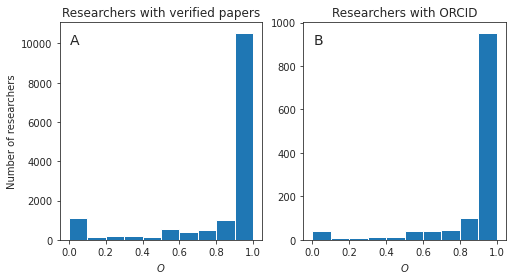

In [21]:
def plot_validation():
    """"""
    fig = plt.figure(figsize=(8,4))
    ax = plt.subplot2grid((1,2), (0,0))
    df = aft_author_df[(aft_author_df.magaid != '') & 
                       (aft_author_df.NumVerifiedMAGPubs > 0)] # at least 1 verified MAG paper
    print(df.shape)
    data = df.NumVerifiedPubsInMAG / df.NumVerifiedMAGPubs
    ax.hist(data)
    ax.text(.05, .9, 'A', transform=ax.transAxes, fontsize=14)
    ax.set_title('Researchers with verified papers')
    ax.set(xlabel='$O$', ylabel='Number of researchers')
    #
    ax = plt.subplot2grid((1,2), (0,1))
    df = orcid_author_df[(orcid_author_df.magaid != '') & 
                         (orcid_author_df.NumPubsORCID) > 0] # at least 1 ORCID paper in MAG
    print(df.shape)
    data = df.NumPubsORCIDInMAG / df.NumPubsORCID
    ax.hist(data)
    ax.text(.05, .9, 'B', transform=ax.transAxes, fontsize=14)
    ax.set_title('Researchers with ORCID')
    ax.set(xlabel='$O$')
    plt.savefig('fig/aft_to_mag_author_val.pdf', bbox_inches='tight')

plot_validation()